# **1. Install Required Libraries**

In [70]:
!pip install nltk
!pip install -q wordcloud

In [71]:
import wordcloud
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

# **2. Import Libraries**

In [72]:
#Importing the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.svm import SVC

# Importing the warnings
import warnings
warnings.filterwarnings('ignore')

# **3. Load Dataset**

In [73]:
#https://www.kaggle.com/datasets/venky73/spam-mails-dataset?resource=download

df = pd.read_csv('/content/spam_ham_dataset.csv')

df.head()
df.info()
print('shape of dataset',df.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5171 entries, 0 to 5170
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  5171 non-null   int64 
 1   label       5171 non-null   object
 2   text        5171 non-null   object
 3   label_num   5171 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 161.7+ KB
shape of dataset (5171, 4)


In [74]:
df.isnull().sum()

,0
Unnamed: 0,0
label,0
text,0
label_num,0


In [75]:
print('count of label:\n', df['label'].value_counts())

count of label:
 label
ham     3672
spam    1499
Name: count, dtype: int64


In [76]:
print("Not Spam Ratio:", round(len(df[df['label_num']==0]) / len(df['label_num']), 2) * 100, "%")
print("Spam Ratio:", round(len(df[df['label_num']==1]) / len(df['label_num']), 2) * 100, "%")

Not Spam Ratio: 71.0 %
Spam Ratio: 28.999999999999996 %


# **4. Text Preprocessing**

In [77]:
# Add message length column
df['length'] = df.text.str.len()
df.head()

,Unnamed: 0,label,text,label_num,length
0,605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0,327
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0,97
2,3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0,2524
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1,414
4,2030,ham,Subject: re : indian springs\r\nthis deal is t...,0,336


In [78]:
# Convert to lowercase
df['text']=df['text'].str.lower()
df.head()

,Unnamed: 0,label,text,label_num,length
0,605,ham,subject: enron methanol ; meter # : 988291\r\n...,0,327
1,2349,ham,"subject: hpl nom for january 9 , 2001\r\n( see...",0,97
2,3624,ham,"subject: neon retreat\r\nho ho ho , we ' re ar...",0,2524
3,4685,spam,"subject: photoshop , windows , office . cheap ...",1,414
4,2030,ham,subject: re : indian springs\r\nthis deal is t...,0,336


In [79]:
# Replace emails, URLs, currency symbols, phone numbers, and numbers

df['text'] = df['text'].str.replace(r'^.+@[^\.].*\.[a-z]{2,}$','emailaddress')
df['text'] = df['text'].str.replace(r'^http\://[a-zA-Z0-9\-\.]+\.[a-zA-Z]{2,3}(/\S*)?$','webaddress')
df['text'] = df['text'].str.replace(r'£|\$', 'dollers')
df['text'] = df['text'].str.replace(r'^\(?[\d]{3}\)?[\s-]?[\d]{3}[\s-]?[\d]{4}$','phonenumber')
df['text'] = df['text'].str.replace(r'\d+(\.\d+)?', 'numbr')

# Remove punctuation and extra spaces
df['text'] = df['text'].str.replace(r'[^\w\d\s]', ' ')
df['text'] = df['text'].str.replace(r'\s+', ' ')
df['text'] = df['text'].str.replace(r'^\s+|\s+?$', '')

In [80]:
df.head()

,Unnamed: 0,label,text,label_num,length
0,605,ham,subject: enron methanol ; meter # : 988291\r\n...,0,327
1,2349,ham,"subject: hpl nom for january 9 , 2001\r\n( see...",0,97
2,3624,ham,"subject: neon retreat\r\nho ho ho , we ' re ar...",0,2524
3,4685,spam,"subject: photoshop , windows , office . cheap ...",1,414
4,2030,ham,subject: re : indian springs\r\nthis deal is t...,0,336


In [81]:
# Remove stopwords
import string
import nltk
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english') + ['u', 'ü', 'ur', '4', '2', 'im', 'dont', 'doin', 'ure'])
df['text'] = df['text'].apply(lambda x: " ".join(term for term in x.split() if term not in stop_words))

In [82]:
# New column after cleaning
df['clean_length'] = df.text.str.len()
df.head()

,Unnamed: 0,label,text,label_num,length,clean_length
0,605,ham,subject: enron methanol ; meter # : 988291 fol...,0,327,258
1,2349,ham,"subject: hpl nom january 9 , 2001 ( see attach...",0,97,91
2,3624,ham,"subject: neon retreat ho ho ho , ' around wond...",0,2524,1583
3,4685,spam,"subject: photoshop , windows , office . cheap ...",1,414,403
4,2030,ham,subject: : indian springs deal book teco pvr r...,0,336,204


In [83]:
# Show text length info
print("Original Length:",df.length.sum())
print("Cleaned Length:",df.clean_length.sum())
print("Total Words Removed:",(df.length.sum()) - (df.clean_length.sum()))

Original Length: 5421235
Cleaned Length: 4319627
Total Words Removed: 1101608


# **5. Exploratory Data Analysis (EDA)**

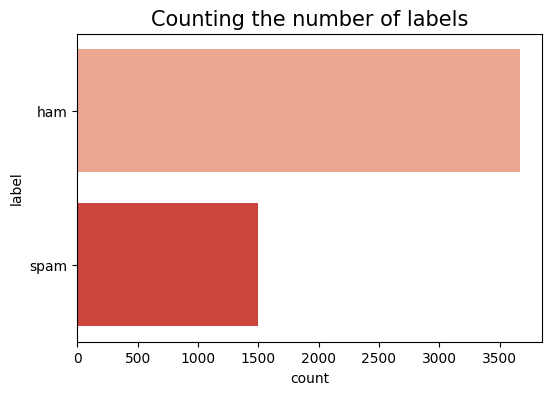

label
ham     3672
spam    1499
Name: count, dtype: int64


In [84]:
# Countplot of labels
plt.figure(figsize=(6,4))
sns.countplot(df['label'],palette= 'Reds')
plt.title("Counting the number of labels",fontsize=15)
plt.xticks(rotation='horizontal')
plt.show()
print(df.label.value_counts())

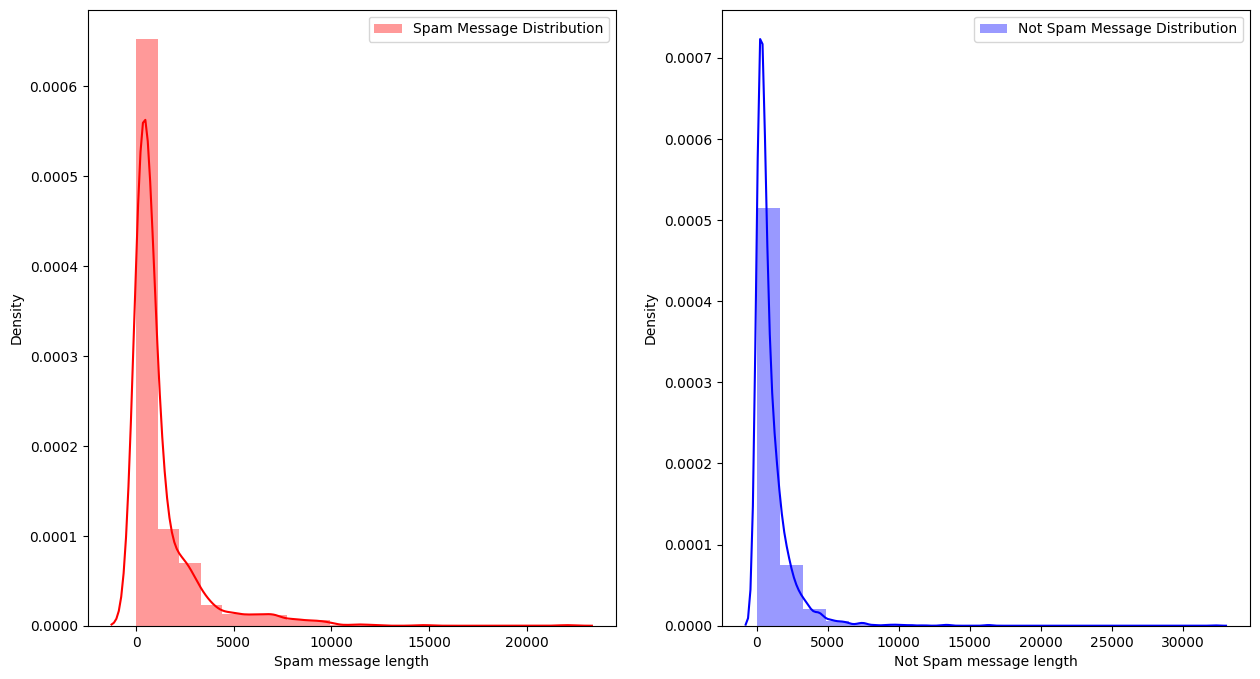

In [85]:
# Distribution of message lengths (original)

f,ax = plt.subplots(1,2,figsize=(15,8))

sns.distplot(df[df['label']=="spam"]['length'],bins=20, ax=ax[0],label='Spam Message Distribution',color='r')
ax[0].set_xlabel('Spam message length')
ax[0].legend()

sns.distplot(df[df['label']=="ham"]['length'],bins=20, ax=ax[1],label='Not Spam Message Distribution',color='b')
ax[1].set_xlabel('Not Spam message length')
ax[1].legend()

plt.show()

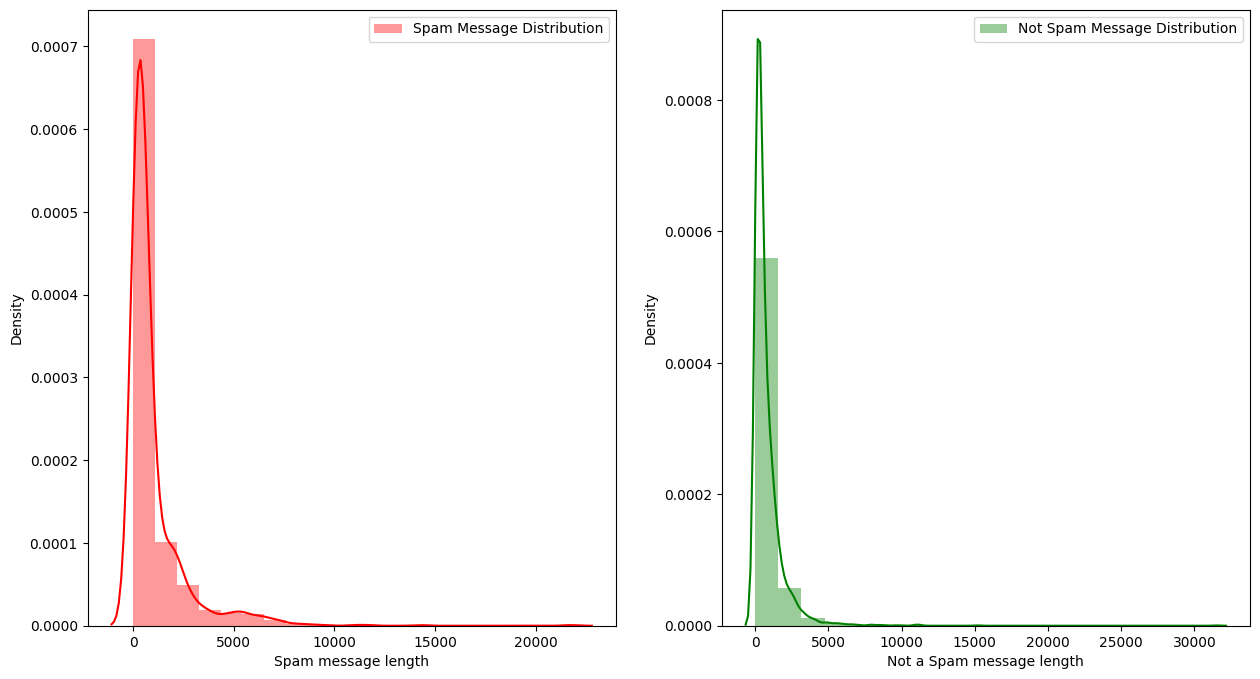

In [86]:
# Distribution of message lengths (cleaned)

f,ax = plt.subplots(1,2,figsize=(15,8))

sns.distplot(df[df['label']=="spam"]['clean_length'], bins=20, ax=ax[0],
             label='Spam Message Distribution', color='r')
ax[0].set_xlabel('Spam message length')
ax[0].legend()

sns.distplot(df[df['label']=="ham"]['clean_length'], bins=20, ax=ax[1],
             label='Not Spam Message Distribution', color='g')
ax[1].set_xlabel('Not a Spam message length')
ax[1].legend()

plt.show()

# **6. WordCloud Visualization**

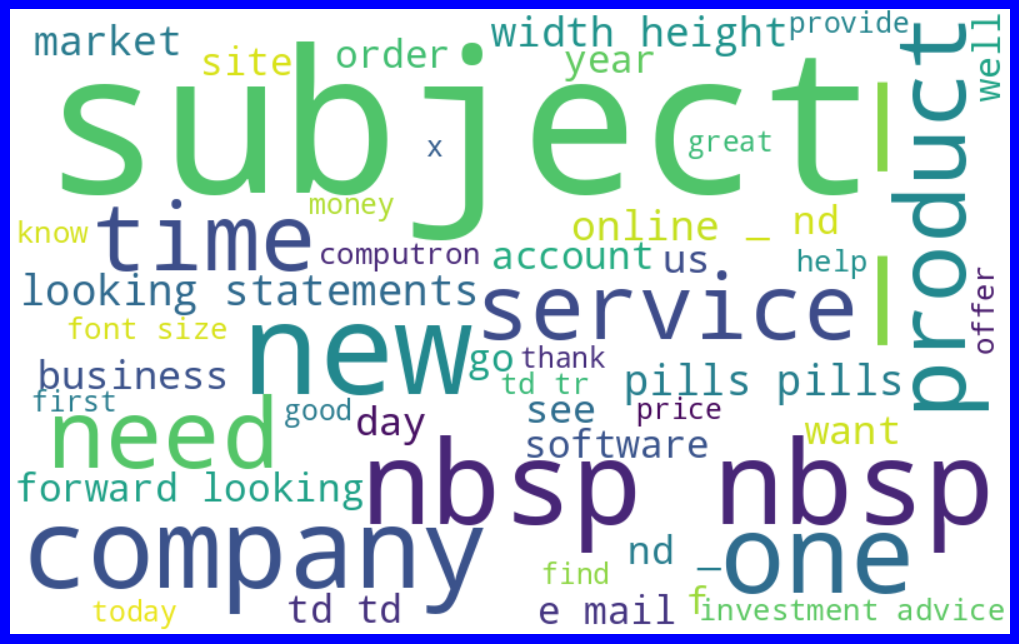

In [87]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Spam WordCloud
spams = df['text'][df['label']=="spam"]
spam_cloud = WordCloud(width=800, height=500, background_color='white', max_words=50).generate(' '.join(spams))

plt.figure(figsize=(10,8), facecolor='b')
plt.imshow(spam_cloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

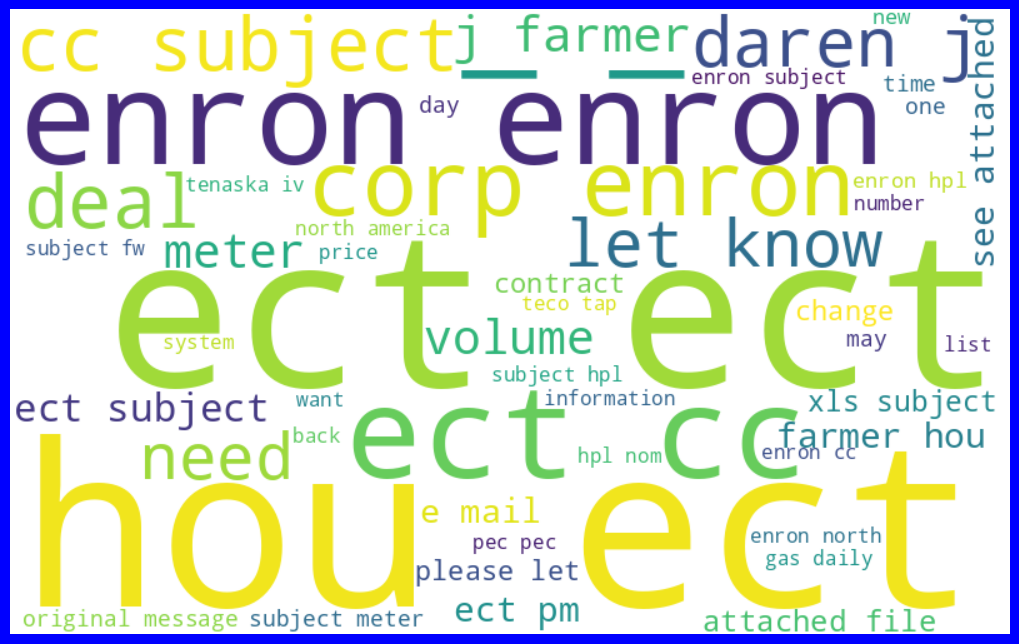

In [88]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Ham WordCloud

not_spams = df['text'][df['label']=="ham"]
ham_cloud = WordCloud(width=800, height=500, background_color='white', max_words=50).generate(' '.join(not_spams))

plt.figure(figsize=(10,8), facecolor='b')
plt.imshow(ham_cloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

# **7. Machine Learning Model (SVM)**

In [89]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC

# TF-IDF Vectorization
tf_vec = TfidfVectorizer()
SVM = SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
features = tf_vec.fit_transform(df['text'])
X = features
y = df['label_num']

In [90]:
# Train/Test Split
X_train,x_test,Y_train,y_test = train_test_split(X,y,random_state=42)

# Instantiate SVM Classifier
SVM.fit(X_train,Y_train)
# Predictions
y_pred = SVM.predict(x_test)
print ('Final score = > ', accuracy_score(y_test,y_pred))

Final score = >  0.9907192575406032


In [91]:
import numpy as np
np.set_printoptions(threshold=np.inf)
print(y_pred)

[0 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0
 1 0 1 0 1 0 1 0 0 0 0 0 1 0 1 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 1 0 0 0 1 1 1 0 0 1 0 0 0 0 1 0 0 0 0 0 0 1 0 1 0 1 0 0 0 1 0 0 0 1 0 1 0
 0 1 0 0 0 0 1 1 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 1 0 0 0 1 0 1
 0 0 1 1 1 1 1 0 0 0 0 0 0 1 1 1 0 1 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 1 0 0 1 0
 0 1 0 1 1 1 1 1 0 0 0 1 1 0 0 1 0 0 1 0 0 1 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0
 1 0 0 1 0 0 0 0 1 0 0 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0
 0 0 0 1 1 1 0 1 0 1 0 1 0 0 1 1 1 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 1 1 0 1 0
 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 1 0 1 0 1 0 1 1 0 0 0 1 0 0 1 0 1 1 1
 0 1 0 1 0 1 1 0 1 1 1 1 0 0 1 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0
 0 1 1 0 0 1 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 1 1 1 0 0 0 1 1 0 0 0 0 0 0
 0 1 0 0 0 1 0 0 0 0 1 0 0 1 0 0 1 1 0 0 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 1 1 1 0 1 1 0 0 0 0 0 

In [92]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99       930
           1       0.97      0.99      0.98       363

    accuracy                           0.99      1293
   macro avg       0.99      0.99      0.99      1293
weighted avg       0.99      0.99      0.99      1293



# **8. Confusion Matrix**

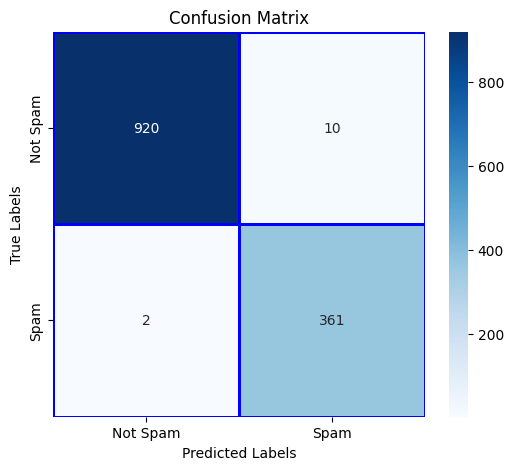

In [93]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(6,5))
sns.heatmap(conf_mat, annot=True, fmt='d', ax=ax, linewidths=2, linecolor='blue', cmap='Blues')
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Not Spam', 'Spam'])
ax.yaxis.set_ticklabels(['Not Spam', 'Spam'])
plt.show()

# **9. Save Model**

In [94]:
import pickle
filename='Email_spam_detect.pkl'
M=open(filename,'wb')
pickle.dump(SVM,M)
M.close()